# Preparation

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Open files with correct encoding
games_2017 = pd.read_html('2017/games.xls', encoding='utf-8')[0]
games_2018 = pd.read_html('2018/games.xls', encoding='utf-8')[0]
games_2019 = pd.read_html('2019/games.xls', encoding='utf-8')[0]

players_2017 = pd.read_html('2017/player-stats.xls', encoding='utf-8')[0]
players_2018 = pd.read_html('2018/player-stats.xls', encoding='utf-8')[0]
players_2019 = pd.read_html('2019/player-stats.xls', encoding='utf-8')[0]

table_2017 = pd.read_html('2017/table.xls', encoding='utf-8')[0]
table_2018 = pd.read_html('2018/table.xls', encoding='utf-8')[0]
table_2019 = pd.read_html('2019/table.xls', encoding='utf-8')[0]

teams_2017 = pd.read_html('2017/team-stats.xls', encoding='utf-8')[0]
teams_2018 = pd.read_html('2018/team-stats.xls', encoding='utf-8')[0]
teams_2019 = pd.read_html('2019/team-stats.xls', encoding='utf-8')[0]

games_2020 = pd.read_html('2020/games.xls', encoding='utf-8')[0]
players_2020 = pd.read_html('2020/player-stats.xls', encoding='utf-8')[0]

#### Games
The most important dataset. Contains information about the matches played per year, like time, \
day, week, who's playing, score, arena and more.
#### Players
Contains information about all players, how well they performed, what team they play on, age and more.
#### Table
Contains final ranks for the teams, scores over the season, won/draw/loss of matches, top scorer.
#### Teams
Contains information about the teams, number of players, average age, performance and more.

In [4]:
# Gather all years in one table.
tot_games = pd.concat((pd.concat((games_2017, games_2018)), games_2019))
tot_teams = pd.concat((pd.concat((teams_2017, teams_2018)), teams_2019))

<p>
We are interested in the amount of goals one team scores against the opponent.
Therefore I have chosen these features I would like to make.<p/>

<p>
AvgGls           - avg goals                          - scoring team<br>
AvgConceded      - avg conceded                       - opponent team<br>
AvgGlsHA         - avg goals on home or away venue    - scoring team<br>
Venue_H          - playing on home venue              - scoring team<br>
Venue_A          - playing on away venue              - scoring team<br>
AvgConcededHA    - avg conceded on home or away venue - opponent team<br>
AvgGlsPrVenue    - avg goals on this venue<br>
AvgPrevMatches   - avg goals scored in previous match - scoring team<br>
AvgAge           - avg age of team<br>
AvgAgeOpp        - avg age of opponent team
<p/>

In [5]:
# Drop rows where all values are NaN and iterate to change row format of Score from "2-1" to two rows with 2 and 1 as Score.
# Only choosing the columns I am interested in.
iter_data = tot_games.loc[:, ['Score', 'Home', 'Away', 'Venue', 'Attendance']].dropna(how='all').reset_index()
df_games = pd.DataFrame([], index=[], columns=['Score', 'Home', 'Away', 'Venue', 'Attendance'])
iter_data_2020 = games_2020.loc[:, ['Home', 'Away', 'Venue', 'Wk']].dropna(how='all').reset_index()
df_games_2020 = pd.DataFrame([], index=[], columns=['Home', 'Away', 'Venue', 'Wk'])
# For 2017-2019 games  
for (i, row) in iter_data.iterrows():
    homeGls = row[1][0]
    awayGls = row[1][2]
    home = row[2]
    away = row[3]
    # første kamp rad
    row[1] = homeGls
    row[5] = 1
    df_games = df_games.append(row.drop(['index']))
    # andre kamp rad
    row[1] = awayGls
    row[2] = away
    row[3] = home
    row[5] = 0
    df_games = df_games.append(row.drop(['index']))

# For 2020 games    
for (i, row) in iter_data_2020.iterrows():
    home = row[1]
    away = row[2]
    # første kamp rad
    row[4] = 1
    df_games_2020 = df_games_2020.append(row.drop(['index']))
    # andre kamp rad
    row[1] = away
    row[2] = home
    row[4] = 0
    df_games_2020 = df_games_2020.append(row.drop(['index']))
# Making new column names and removing two matches where IF Fløya shows up.
df_games = df_games.rename(columns={'Home': 'Team', 'Away': 'Opponent', 'Attendance': 'Venue_HA'}).reset_index(drop=True)
df_games = df_games.iloc[:-4]
df_games_2020 = df_games_2020.rename(columns={'Home': 'Team', 'Away': 'Opponent', 'Wk': 'Venue_HA'}).reset_index(drop=True)
df_games_2020

,Team,Opponent,Venue,Venue_HA
0,Trondheims-Ørn,LSK Kvinner,Ørn Arena,1
1,LSK Kvinner,Trondheims-Ørn,Ørn Arena,0
2,Røa,Arna-Bjørnar,Røabanen,1
3,Arna-Bjørnar,Røa,Røabanen,0
4,Avaldsnes,Lyn,Avaldsnes Idrettssenter,1
...,...,...,...,...
179,Avaldsnes,Sandviken,Stemmemyren kunstgressbane,0
180,LSK Kvinner,Lyn,LSK-hallen,1
181,Lyn,LSK Kvinner,LSK-hallen,0
182,Vålerenga,Arna-Bjørnar,Vålerenga kultur- og idrettspark kunstgr...,1


In [6]:
# Making a dataframe of averages from the teams df.
# list of team names
all_teams = tot_teams.drop_duplicates(('Unnamed: 0_level_0', 'Squad'), ignore_index=True)['Unnamed: 0_level_0']

for (i, row) in all_teams.iterrows():
    # Number of matches
    games_played = len(df_games.loc[df_games['Team'] == row.values[0]])
    games_played_venue = games_played/2
    
    # Calculating averages
    avgGls = sum(map(int, df_games.loc[df_games['Team'] == row.values[0]]['Score'].values))/games_played
    avgConceded = sum(map(int, df_games.loc[df_games['Opponent'] == row.values[0]]['Score'].values))/games_played
    avgGlsHome = sum(map(int, df_games.loc[(df_games['Team'] == row.values[0]) & (df_games['Venue_HA'] == 1)]['Score'].values))/games_played_venue
    avgGlsAway = sum(map(int, df_games.loc[(df_games['Team'] == row.values[0]) & (df_games['Venue_HA'] == 0)]['Score'].values))/games_played_venue
    avgConcededHome = sum(map(int, df_games.loc[(df_games['Opponent'] == row.values[0]) & (df_games['Venue_HA'] == 0)]['Score'].values))/games_played_venue
    avgConcededAway = sum(map(int, df_games.loc[(df_games['Opponent'] == row.values[0]) & (df_games['Venue_HA'] == 1)]['Score'].values))/games_played_venue
    avgAge = sum(tot_teams.loc[tot_teams[('Unnamed: 0_level_0', 'Squad')] == row.values[0], ('Unnamed: 2_level_0', 'Age')])/len(tot_teams.loc[tot_teams[('Unnamed: 0_level_0', 'Squad')] == row.values[0], ('Unnamed: 2_level_0', 'Age')])
    
    all_teams.loc[i, 'AvgGls'] = avgGls
    all_teams.loc[i, 'AvgConceded'] = avgConceded
    all_teams.loc[i, 'AvgGlsHome'] = avgGlsHome
    all_teams.loc[i, 'AvgGlsAway'] = avgGlsAway
    all_teams.loc[i, 'AvgConcededHome'] = avgConcededHome
    all_teams.loc[i, 'AvgConcededAway'] = avgConcededAway
    all_teams.loc[i, 'AvgAge'] = avgAge

all_teams

,Squad,AvgGls,AvgConceded,AvgGlsHome,AvgGlsAway,AvgConcededHome,AvgConcededAway,AvgAge
0,Arna-Bjørnar,1.787879,1.439394,2.030303,1.545455,1.272727,1.606061,22.100000
1,Avaldsnes,1.742424,1.333333,2.000000,1.484848,1.060606,1.606061,24.633333
2,Grand Bodø,1.136364,3.204545,1.181818,1.090909,2.772727,3.636364,23.050000
3,Klepp,1.833333,0.969697,2.090909,1.575758,0.757576,1.181818,24.533333
4,Kolbotn,1.303030,1.772727,1.393939,1.212121,1.727273,1.818182,21.633333
5,LSK Kvinner,2.878788,0.772727,3.060606,2.696970,0.696970,0.848485,24.533333
6,Medkila,0.409091,3.136364,0.454545,0.363636,2.727273,3.545455,20.900000
7,Røa,1.878788,1.590909,2.272727,1.484848,1.727273,1.454545,22.800000
8,Sandviken,1.636364,1.439394,1.969697,1.303030,1.272727,1.606061,25.366667
9,Stabæk,1.378788,1.560606,1.606061,1.151515,1.151515,1.969697,24.600000


In [7]:
# Making a df for venues to find AvgGlsPrVenue
# Note some of the venues have few entries, and therefore bad averages, for example Strømmen Stadion.
# Average for IF Fløya was 5.0 over two games, therefore I removed them, this can be done safely 
#   as IF-Fløya does not appear in 2020 data
df_venues = df_games.loc[:, ['Venue']].drop_duplicates('Venue', ignore_index=True)

for (i, row) in df_venues.iterrows():
    venue = df_games.loc[df_games['Venue'] == row.values[0]]['Score'].values
    avgGlsPrVenue = sum(map(int, venue))/len(venue)
    df_venues.loc[i, 'AvgGlsPrVenue'] = avgGlsPrVenue
    
df_venues

,Venue,AvgGlsPrVenue
0,Harstad Stadion,1.590909
1,Avaldsnes Idrettssenter,1.562500
2,Nordlandshallen,1.977273
3,Røabanen,2.000000
4,LSK-hallen,1.875000
5,Ørn Arena,1.270833
6,Arna Idrettspark,1.612903
7,Vallhall Arena,1.166667
8,Sofiemyr stadion,1.580000
9,Nadderud Stadion,1.406250


In [69]:
# Making final dfs for model training and 2020 prediction
# y_all: labels
# X_all: features, x-variables
y_all = df_games['Score']
X_all = df_games.drop(['Score'], axis=1)
X_all_2020 = df_games_2020

# Adding column names


def put_it_in_there(datafr):
    for i in ['AvgGls', 'AvgConceded', 'AvgGlsHA', 'Venue_H', 'Venue_A', 'AvgConcededHA', 'AvgGlsPrVenue', 'AvgAge', 'AvgAgeOpp']:
        datafr[i] = 0
    for (i, row) in datafr.iterrows():
        datafr.loc[i, 'AvgGls'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgGls'].values[0]
        datafr.loc[i, 'AvgConceded'] = all_teams.loc[all_teams['Squad'] == row.values[1], 'AvgConceded'].values[0]
        datafr.loc[i, 'AvgGlsPrVenue'] = df_venues.loc[df_venues['Venue'] == row.values[2], 'AvgGlsPrVenue'].values[0]
        datafr.loc[i, 'AvgAge'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgAge'].values[0]
        datafr.loc[i, 'AvgAgeOpp'] = all_teams.loc[all_teams['Squad'] == row.values[1], 'AvgAge'].values[0]
        
        # team is playing on home venue
        if row.values[3] == 1:
            datafr.loc[i, 'AvgGlsHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgGlsHome'].values[0]
            datafr.loc[i, 'Venue_H'] = 1
            datafr.loc[i, 'AvgConcededHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgConcededAway'].values[0]

        # team is playing on away venue
        elif row.values[3] == 0:
            datafr.loc[i, 'AvgGlsHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgGlsAway'].values[0]
            datafr.loc[i, 'Venue_A'] = 1
            datafr.loc[i, 'AvgConcededHA'] = all_teams.loc[all_teams['Squad'] == row.values[0], 'AvgConcededHome'].values[0]

put_it_in_there(X_all)
put_it_in_there(X_all_2020)

# Dropping columns with categorical data
X_all = X_all.drop(['Team', 'Opponent', 'Venue', 'Venue_HA'], axis=1)
X_all_2020 = X_all_2020.drop(['Venue','Venue_HA'], axis=1)
X_all.head()

,AvgGls,AvgConceded,AvgGlsHA,Venue_H,Venue_A,AvgConcededHA,AvgGlsPrVenue,AvgAge,AvgAgeOpp
0,0.409091,1.439394,0.454545,1,0,3.545455,1.590909,20.900000,25.366667
1,1.636364,3.136364,1.303030,0,1,1.272727,1.590909,25.366667,20.900000
2,1.742424,1.393939,2.000000,1,0,1.606061,1.562500,24.633333,25.533333
3,1.757576,1.333333,1.787879,0,1,1.121212,1.562500,25.533333,24.633333
4,1.136364,1.439394,1.181818,1,0,3.636364,1.977273,23.050000,22.100000


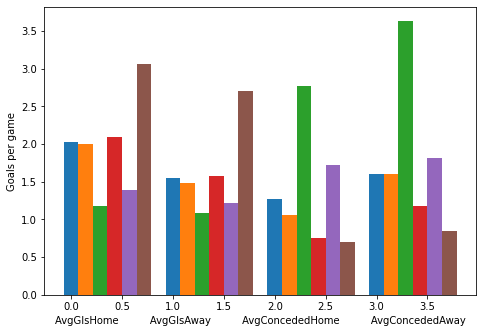

In [70]:
x=[2,3,4]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['AvgGlsHome', 'AvgGlsAway', 'AvgConcededHome', 'AvgConcededAway']

for i in range(6):
    data = list(all_teams.loc[i, ['AvgGlsHome', 'AvgGlsAway', 'AvgConcededHome', 'AvgConcededAway']])
    ax.bar(X + i*1/7, data, width=1/7)

plt.xlabel('AvgGlsHome          AvgGlsAway          AvgConcededHome          AvgConcededAway')
plt.ylabel('Goals per game')
# Her er en enkel bar graf som viser sammenhengen mellom gjennomsnitt mål og innsluppet mål på hjemme
# og bortebane. 
# Lag på hjemmebane scorer flere mål og slipper inn færre mål enn på bortebane.
# Fikk ikke til å sette labels på gruppene men jeg håper det er tydelig nok
plt.show()

# Model

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error

In [76]:
# Fixing some dtype: object in y_all and making numpy arrays because that's what sklearn likes
y_all = y_all.astype('int64')
y_all = np.array(y_all)
X_all = np.array(X_all)

# Splitting data into Training, Validation and Test sets.
X_train_val, X_test, y_train_val, y_test = train_test_split(X_all, y_all, train_size=0.75, random_state=8)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size=0.75, random_state=8)

"""
# I scaled to standardize data but did it incorrectly and got biased models.
# I then wanted to implement it correctly, but it quickly proved difficult as I was basically finished when I noticed.
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Defining scalers
all_scaler = StandardScaler().fit(X_all)
train_val_scaler = StandardScaler().fit(X_train_val)
train_scaler = StandardScaler().fit(X_train)

# Scaling X datasets
X_all = all_scaler.transform(X_all)
X_train_val, X_test = (train_val_scaler.transform(i) for i in [X_train_val, X_test])
X_train, X_val = (train_scaler.transform(i) for i in [X_train, X_val])
"""

# Exporting to csv, used for webpage
pd.DataFrame(X_all).to_csv('X_all.csv', index=False)
pd.DataFrame(y_all).to_csv('y_all.csv', index=False)

# Will be using 5 splits for cross validations
splits = 5

## Tweaking hyperparameters

##### Linear Regression

In [77]:
linreg = LinearRegression()
score = cross_val_score(linreg, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
rmse = np.sqrt(-sum(score)/splits)
print(f"RMSE: {rmse:.5f}\n")
    

RMSE: 1.25899



##### K-Nearest Neighbors

Text(0, 0.5, 'RMSE')

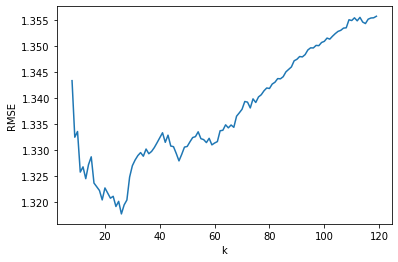

In [81]:
rmses = []
lowest = 999
for i in range(8, 120):
    neigh = KNeighborsRegressor(n_neighbors=i)
    score = cross_val_score(neigh, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    rmses.append(rmse)
    if rmse<lowest:
        lowest = rmse
        #print(f"{i}: RMSE: {rmse:.5f}\n")

fig = plt.plot(range(8, 120), rmses)
plt.xlabel('k')
plt.ylabel('RMSE')
# 26 neighbors seems like the best K value

##### Decision Tree Regressor

In [82]:
# function to find best ccp_alpha
def find_alpha(X_train, y_train, splits):
    alphas = []
    mses = []
    defaultTree = DecisionTreeRegressor(random_state=8, ccp_alpha=0.0)
    path = defaultTree.cost_complexity_pruning_path(X_train, y_train, sample_weight=None)
    
    skf = StratifiedKFold(n_splits=splits)
    for i, j in skf.split(X_train_val, y_train_val):
        X_train, X_val, y_train, y_val = X_train_val[i], X_train_val[j], y_train_val[i], y_train_val[j]
        best_ccp_alpha = 0.0
        best_mse = 999
        # We find the best alpha in the cost_complexity_pruning_path, that minimizes mse
        for ccp_alpha in path.ccp_alphas:
            if ccp_alpha > 0:
                clf = DecisionTreeRegressor(random_state=8, ccp_alpha=ccp_alpha)
                clf.fit(X_train, y_train)
                mse = mean_squared_error(y_val, clf.predict(X_val))
                if mse < best_mse:
                    best_ccp_alpha = ccp_alpha
                    best_mse = mse
        alphas.append(best_ccp_alpha)
        mses.append(best_mse)
        
    # returning the means
    avg_alpha = np.mean(alphas)
    avg_mse = np.mean(mses)
    return avg_alpha, avg_mse

In [83]:
# Decision Tree Regressor
avg_alpha, avg_mse = find_alpha(X_train, y_train, splits)
print(f"avgAlpha: {avg_alpha}, avgRMSE: {np.sqrt(avg_mse)}")

avgAlpha: 0.022579103403316356, avgRMSE: 1.328820756941311


##### Support Vector Regression

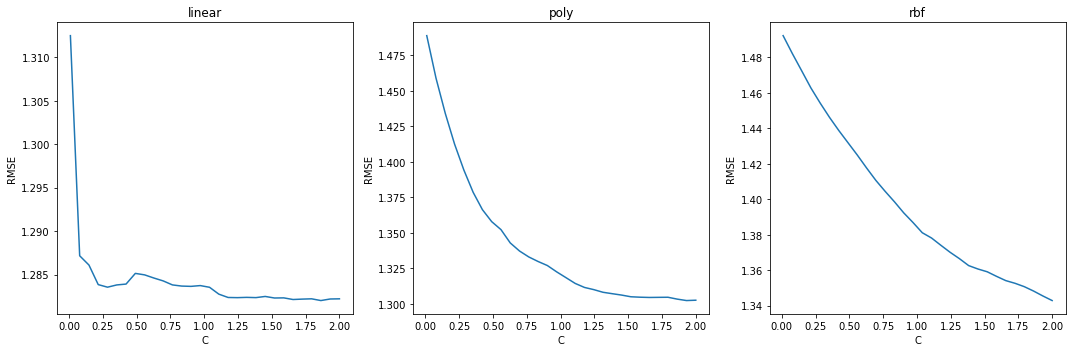

In [84]:
kernels = {
    'linear': [],
    'poly'  : [],
    'rbf'   : []
}
c_linspace = np.linspace(0.01, 2, 30)
for kernel in kernels.keys():
    lowest = 999
    for i in c_linspace:
        svr = SVR(kernel=kernel, C=i)
        score = cross_val_score(svr, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
        rmse = np.sqrt(-sum(score)/splits)
        kernels[kernel].append(rmse)
        if rmse < lowest:
            lowest = rmse
            #print(f"SVR:{kernel}:{i:.5f}\nRMSE: {rmse:.5f}")
        
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
ax1.plot(c_linspace, kernels['linear'])
ax1.set_title('linear')
ax1.set_xlabel('C')
ax1.set_ylabel('RMSE')
ax2.plot(c_linspace, kernels['poly'])
ax2.set_title('poly')
ax2.set_xlabel('C')
ax2.set_ylabel('RMSE')
ax3.plot(c_linspace, kernels['rbf'])
ax3.set_title('rbf')
ax3.set_xlabel('C')
ax3.set_ylabel('RMSE')
fig.tight_layout()

# A linear kernel SVR with C=1.86276 seems good

##### Random Forest Regressor

In [85]:
ns = [30, 50, 70, 100, 300, 500]
lowest = 999
for n in ns:
    forest = RandomForestRegressor(n_estimators=n, ccp_alpha=avg_alpha, random_state=8)
    score = cross_val_score(forest, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    if rmse < lowest:
        lowest = rmse
        print(f"Forest with {n} estimators\nRMSE: {rmse:.5f}")

# We see 100 estimators gets better results

Forest with 30 estimators
RMSE: 1.33261
Forest with 50 estimators
RMSE: 1.32810
Forest with 70 estimators
RMSE: 1.32654
Forest with 100 estimators
RMSE: 1.32600


##### Gradient Boosting Regressor

In [87]:
ls = [0.08, 0.099, 0.12]
lowest = 999
for n in ns:
    for l in ls:
        gboost = GradientBoostingRegressor(n_estimators=n, learning_rate=l, max_depth=1, random_state=8)
        score = cross_val_score(gboost, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
        rmse = np.sqrt(-sum(score)/splits)
        if rmse<lowest:
            lowest = rmse
            print(f"gboost | n={n} | l={l}\nRMSE: {rmse:.5f}")

# gboost with n=100, l=0.99 and max depth 1 gives 1.29422

gboost | n=30 | l=0.08
RMSE: 1.32636
gboost | n=30 | l=0.099
RMSE: 1.31571
gboost | n=30 | l=0.12
RMSE: 1.30794
gboost | n=50 | l=0.08
RMSE: 1.30445
gboost | n=50 | l=0.099
RMSE: 1.29925
gboost | n=50 | l=0.12
RMSE: 1.29602
gboost | n=70 | l=0.099
RMSE: 1.29482
gboost | n=70 | l=0.12
RMSE: 1.29447
gboost | n=100 | l=0.099
RMSE: 1.29422


##### AdaBoost Regressor

In [89]:
ns = [30, 50, 70, 100, 300]
ls = [0.05, 0.1, 0.5]
lowest = 999
for n in ns:
    for l in ls:
        tree = DecisionTreeRegressor(random_state=8, ccp_alpha=avg_alpha)
        # add tree to or remove tree from first argument of AdaBoostRegressor()
        adaboost = AdaBoostRegressor(tree, n_estimators=n, learning_rate=l, random_state=8)
        score = cross_val_score(adaboost, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
        rmse = np.sqrt(-sum(score)/splits)
        if rmse<lowest:
            lowest = rmse
            print(f"adaBoost | n={n} | l={l}\nRMSE: {rmse:.5f}")

# adaBoost with n=30, l=0.1 and pruned dtree gives 1.35680, might have messed up at the pruning part
# adaBoost with n=70, l=0.05 and max_depth=3 dtree gives 1.30600

adaBoost | n=30 | l=0.05
RMSE: 1.35963
adaBoost | n=30 | l=0.1
RMSE: 1.35680


##### Evaluating Models

In [90]:
models = {
    "LinReg"        : LinearRegression(),
    "KNeighbors"    : KNeighborsRegressor(n_neighbors=26),
    "DecisionTree"  : DecisionTreeRegressor(ccp_alpha=avg_alpha, random_state=8),
    "SupportVector" : SVR(kernel='linear', C=1.86276),
    "RandomForest"  : RandomForestRegressor(n_estimators=100, ccp_alpha=avg_alpha, random_state=8),
    "GradientBoost" : GradientBoostingRegressor(n_estimators=100, learning_rate=0.099, max_depth=1, random_state=8),
    "AdaBoost"      : AdaBoostRegressor(n_estimators=70, learning_rate=0.05, random_state=8),
}

In [91]:
for name, model in models.items():
    score = cross_val_score(model, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    print(f"{name}\nRMSE: {rmse:.5f}\n")

LinReg
RMSE: 1.25899

KNeighbors
RMSE: 1.31781

DecisionTree
RMSE: 1.37749

SupportVector
RMSE: 1.28205

RandomForest
RMSE: 1.32600

GradientBoost
RMSE: 1.29422

AdaBoost
RMSE: 1.30600



##### Results

We see that Linear Regression outperforms the other models with a RMSE of 1.25899\
If linear models are so good, let me try some additional ones.

In [92]:
from sklearn.linear_model import Ridge, ElasticNet, Lasso
# All models have tunable alphas

##### Round 2

ridge | alpha=1.00000
RMSE: 1.25890
ridge | alpha=1.18367
RMSE: 1.25889
ridge | alpha=1.36735
RMSE: 1.25888
ridge | alpha=1.55102
RMSE: 1.25887
ridge | alpha=1.73469
RMSE: 1.25886
ridge | alpha=1.91837
RMSE: 1.25885
ridge | alpha=2.10204
RMSE: 1.25884
ridge | alpha=2.28571
RMSE: 1.25884
ridge | alpha=2.46939
RMSE: 1.25883
ridge | alpha=2.65306
RMSE: 1.25883
ridge | alpha=2.83673
RMSE: 1.25883
ridge | alpha=3.02041
RMSE: 1.25882
ridge | alpha=3.20408
RMSE: 1.25882
ridge | alpha=3.38776
RMSE: 1.25882
ridge | alpha=3.57143
RMSE: 1.25882


Text(0, 0.5, 'RMSE')

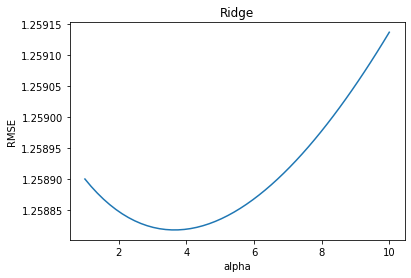

In [95]:
rmses = []
lowest = 999
alphas = np.linspace(1, 10, 50)
for a in alphas:
    ridge = Ridge(alpha=a)
    score = cross_val_score(ridge, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    rmses.append(rmse)
    if rmse < lowest:
        lowest = rmse
        print(f"ridge | alpha={a:.5f}\nRMSE: {rmse:.5f}")
    

fig = plt.plot(alphas, rmses)
plt.title('Ridge')
plt.xlabel('alpha')
plt.ylabel('RMSE')
# ridge with alpha=3.57143 gives 1.25882

elastic | alpha=0.00100
RMSE: 1.25894
elastic | alpha=0.00118
RMSE: 1.25893
elastic | alpha=0.00137
RMSE: 1.25892
elastic | alpha=0.00155
RMSE: 1.25891
elastic | alpha=0.00173
RMSE: 1.25891
elastic | alpha=0.00192
RMSE: 1.25890
elastic | alpha=0.00210
RMSE: 1.25889
elastic | alpha=0.00229
RMSE: 1.25889
elastic | alpha=0.00247
RMSE: 1.25888
elastic | alpha=0.00265
RMSE: 1.25888
elastic | alpha=0.00284
RMSE: 1.25888
elastic | alpha=0.00302
RMSE: 1.25887
elastic | alpha=0.00320
RMSE: 1.25887
elastic | alpha=0.00339
RMSE: 1.25887
elastic | alpha=0.00357
RMSE: 1.25886
elastic | alpha=0.00376
RMSE: 1.25886
elastic | alpha=0.00394
RMSE: 1.25886
elastic | alpha=0.00412
RMSE: 1.25886
elastic | alpha=0.00431
RMSE: 1.25886
elastic | alpha=0.00449
RMSE: 1.25886


Text(0, 0.5, 'RMSE')

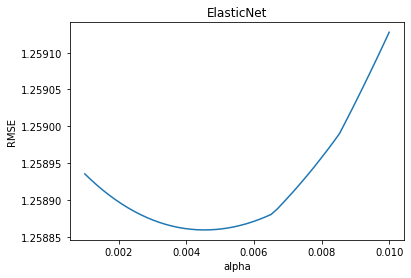

In [98]:
rmses = []
lowest = 999
alphas = np.linspace(0.001, 0.01, 50)
for a in alphas:
    elastic = ElasticNet(alpha=a)
    score = cross_val_score(elastic, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    rmses.append(rmse)
    if rmse < lowest:
        lowest = rmse
        print(f"elastic | alpha={a:.5f}\nRMSE: {rmse:.5f}")

fig = plt.plot(alphas, rmses)
plt.title('ElasticNet')
plt.xlabel('alpha')
plt.ylabel('RMSE')
# elastic with alpha=0.00449 gives 1.25886

lasso | alpha=0.00100
RMSE: 1.25894
lasso | alpha=0.00108
RMSE: 1.25894
lasso | alpha=0.00116
RMSE: 1.25893
lasso | alpha=0.00124
RMSE: 1.25893
lasso | alpha=0.00133
RMSE: 1.25893
lasso | alpha=0.00141
RMSE: 1.25893
lasso | alpha=0.00149
RMSE: 1.25893
lasso | alpha=0.00157
RMSE: 1.25893
lasso | alpha=0.00165
RMSE: 1.25893


Text(0, 0.5, 'RMSE')

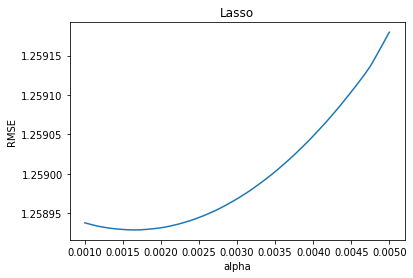

In [105]:
rmses = []
lowest = 999
alphas = np.linspace(0.001, 0.005, 50)
for a in alphas:
    lasso = Lasso(alpha=a)
    score = cross_val_score(lasso, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    rmses.append(rmse)
    if rmse < lowest:
        lowest = rmse
        print(f"lasso | alpha={a:.5f}\nRMSE: {rmse:.5f}")

fig = plt.plot(alphas, rmses)
plt.title('Lasso')
plt.xlabel('alpha')
plt.ylabel('RMSE')
# lasso with alpha=0.00165 gives 1.25893

In [102]:
linear_models = {
    "LinReg": LinearRegression(),
    "Ridge": Ridge(alpha=3.57143),
    "ElasticNet": ElasticNet(alpha=0.00449),
    "Lasso": Lasso(alpha=0.00165)
}

In [103]:
for name, model in linear_models.items():
    score = cross_val_score(model, X_train_val, y_train_val, scoring='neg_mean_squared_error', cv=splits)
    rmse = np.sqrt(-sum(score)/splits)
    print(f"{name}\nRMSE: {rmse:.5f}\n")

LinReg
RMSE: 1.25899

Ridge
RMSE: 1.25882

ElasticNet
RMSE: 1.25886

Lasso
RMSE: 1.25893



Ridge performs the best with a RMSE of 1.25882.\
This will be the final model. We should expect a slightly better RMSE when we train on the entire model because \
we are training on more data and thus generalizing better.\
The final validation X_train_val, y_train_val.

In [107]:
model = Ridge(alpha=3.57143)
score = cross_val_score(model, X_all, y_all, scoring='neg_mean_squared_error', cv=splits)
rmse = np.sqrt(-sum(score)/splits)
print(f"RMSE: {rmse:.5f}")

RMSE: 1.30132


##### Conclusion

Well... didn't get a better RMSE. This could be because of a biased model or more variance in unseen data\
But anyway, this is the final model. Moving on to predicting scores for 2020

# Prediction

##### The 2020 data

In [116]:
X_all_2020

,Team,Opponent,AvgGls,AvgConceded,AvgGlsHA,Venue_H,Venue_A,AvgConcededHA,AvgGlsPrVenue,AvgAge,AvgAgeOpp
0,Trondheims-Ørn,LSK Kvinner,1.318182,0.772727,1.393939,1,0,1.848485,1.270833,21.933333,24.533333
1,LSK Kvinner,Trondheims-Ørn,2.878788,1.606061,2.696970,0,1,0.696970,1.270833,24.533333,21.933333
2,Røa,Arna-Bjørnar,1.878788,1.439394,2.272727,1,0,1.454545,2.000000,22.800000,22.100000
3,Arna-Bjørnar,Røa,1.787879,1.590909,1.545455,0,1,1.272727,2.000000,22.100000,22.800000
4,Avaldsnes,Lyn,1.742424,2.113636,2.000000,1,0,1.606061,1.562500,24.633333,19.950000
...,...,...,...,...,...,...,...,...,...,...,...
179,Avaldsnes,Sandviken,1.742424,1.439394,1.484848,0,1,1.060606,1.724138,24.633333,25.366667
180,LSK Kvinner,Lyn,2.878788,2.113636,3.060606,1,0,0.848485,1.875000,24.533333,19.950000
181,Lyn,LSK Kvinner,1.136364,0.772727,0.818182,0,1,1.954545,1.875000,19.950000,24.533333
182,Vålerenga,Arna-Bjørnar,1.757576,1.439394,1.727273,1,0,1.666667,1.433333,25.533333,22.100000


In [117]:
model = Ridge(alpha=3.57143)
model.fit(X_all, y_all)
y_pred = model.predict(np.array(X_all_2020.iloc[:, 2:]))

In [118]:
predictions = X_all_2020.loc[:, ['Team', 'Opponent']].assign(Score=pd.Series(map(round, y_pred)))
predictions.to_csv(path_or_buf='predictions.csv', index=False)